# PRJNA1088471 - Overton et al.

Article (preprint) link: https://www.researchsquare.com/article/rs-4183960/v1

In [1]:
suppressPackageStartupMessages({
    library(provoc)
    library(here)
    library(ggplot2)
    library(lubridate)
})


In [2]:
coco <- read.csv(
    here("data", "processed", 
        "PRJNA1088471_processed.csv.gz")
)
coco$mutation <- parse_mutations(coco$label)
head(coco)


,position,label,mutation,frequency,coverage,count,sra,date,sample_name,avg_spot_len,bases,bioproject,location,ww_population,zone
,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<lgl>,<chr>
1,10007,+10008.T,ins:10008:1,0,33,0,SRR28354798,2023-07-15,HighlandCreek-20230715,347,271875121,PRJNA1088471,HighlandCreek,NA,Toronto
2,10025,+10026.A,ins:10026:1,0,33,0,SRR28354798,2023-07-15,HighlandCreek-20230715,347,271875121,PRJNA1088471,HighlandCreek,NA,Toronto
3,10046,+10047.T,ins:10047:1,0,30,0,SRR28354798,2023-07-15,HighlandCreek-20230715,347,271875121,PRJNA1088471,HighlandCreek,NA,Toronto
4,10059,+10060.T,ins:10060:1,0,30,0,SRR28354798,2023-07-15,HighlandCreek-20230715,347,271875121,PRJNA1088471,HighlandCreek,NA,Toronto
5,10133,+10134.T,ins:10134:1,0,51,0,SRR28354798,2023-07-15,HighlandCreek-20230715,347,271875121,PRJNA1088471,HighlandCreek,NA,Toronto
6,10160,+10161.T,ins:10161:1,0,54,0,SRR28354798,2023-07-15,HighlandCreek-20230715,347,271875121,PRJNA1088471,HighlandCreek,NA,Toronto


In [3]:
lineages_in_paper <- c("BQ", "BQ.1", "BA.1", "BA.2.75", "BF.1",
    "XBB", "XBB.1.16", "XBB.1.5", "XBB.1.9")
barcodes <- provoc::usher_barcodes()
available_lineages <- intersect(lineages_in_paper, rownames(barcodes))
barcodes <- filter_lineages(barcodes, available_lineages)
rownames(barcodes)


[1] "XBB.1.16" "XBB.1.9"  "XBB.1.5"  "XBB"      "BA.2.75"  "BQ.1"     "BF.1"    
[8] "BA.1"

In [4]:
system.time(
    res <- provoc(count / coverage ~ .,
        data = coco,
        lineage_defs = barcodes,
        by = "sra")
)
head(res)


   user  system elapsed 
346.475 109.914 502.629 

,rho,ci_low,ci_high,lineage,sra,date,sample_name,avg_spot_len,bases,bioproject,location,ww_population,zone
,<dbl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<lgl>,<chr>
1,1.251373e-02,NA,NA,XBB.1.16,SRR28354798,2023-07-15,HighlandCreek-20230715,347,271875121,PRJNA1088471,HighlandCreek,NA,Toronto
2,9.225384e-02,NA,NA,XBB.1.9,SRR28354798,2023-07-15,HighlandCreek-20230715,347,271875121,PRJNA1088471,HighlandCreek,NA,Toronto
3,8.223831e-01,NA,NA,XBB.1.5,SRR28354798,2023-07-15,HighlandCreek-20230715,347,271875121,PRJNA1088471,HighlandCreek,NA,Toronto
4,1.206524e-08,NA,NA,XBB,SRR28354798,2023-07-15,HighlandCreek-20230715,347,271875121,PRJNA1088471,HighlandCreek,NA,Toronto
5,6.101687e-03,NA,NA,BA.2.75,SRR28354798,2023-07-15,HighlandCreek-20230715,347,271875121,PRJNA1088471,HighlandCreek,NA,Toronto
6,7.054845e-06,NA,NA,BQ.1,SRR28354798,2023-07-15,HighlandCreek-20230715,347,271875121,PRJNA1088471,HighlandCreek,NA,Toronto


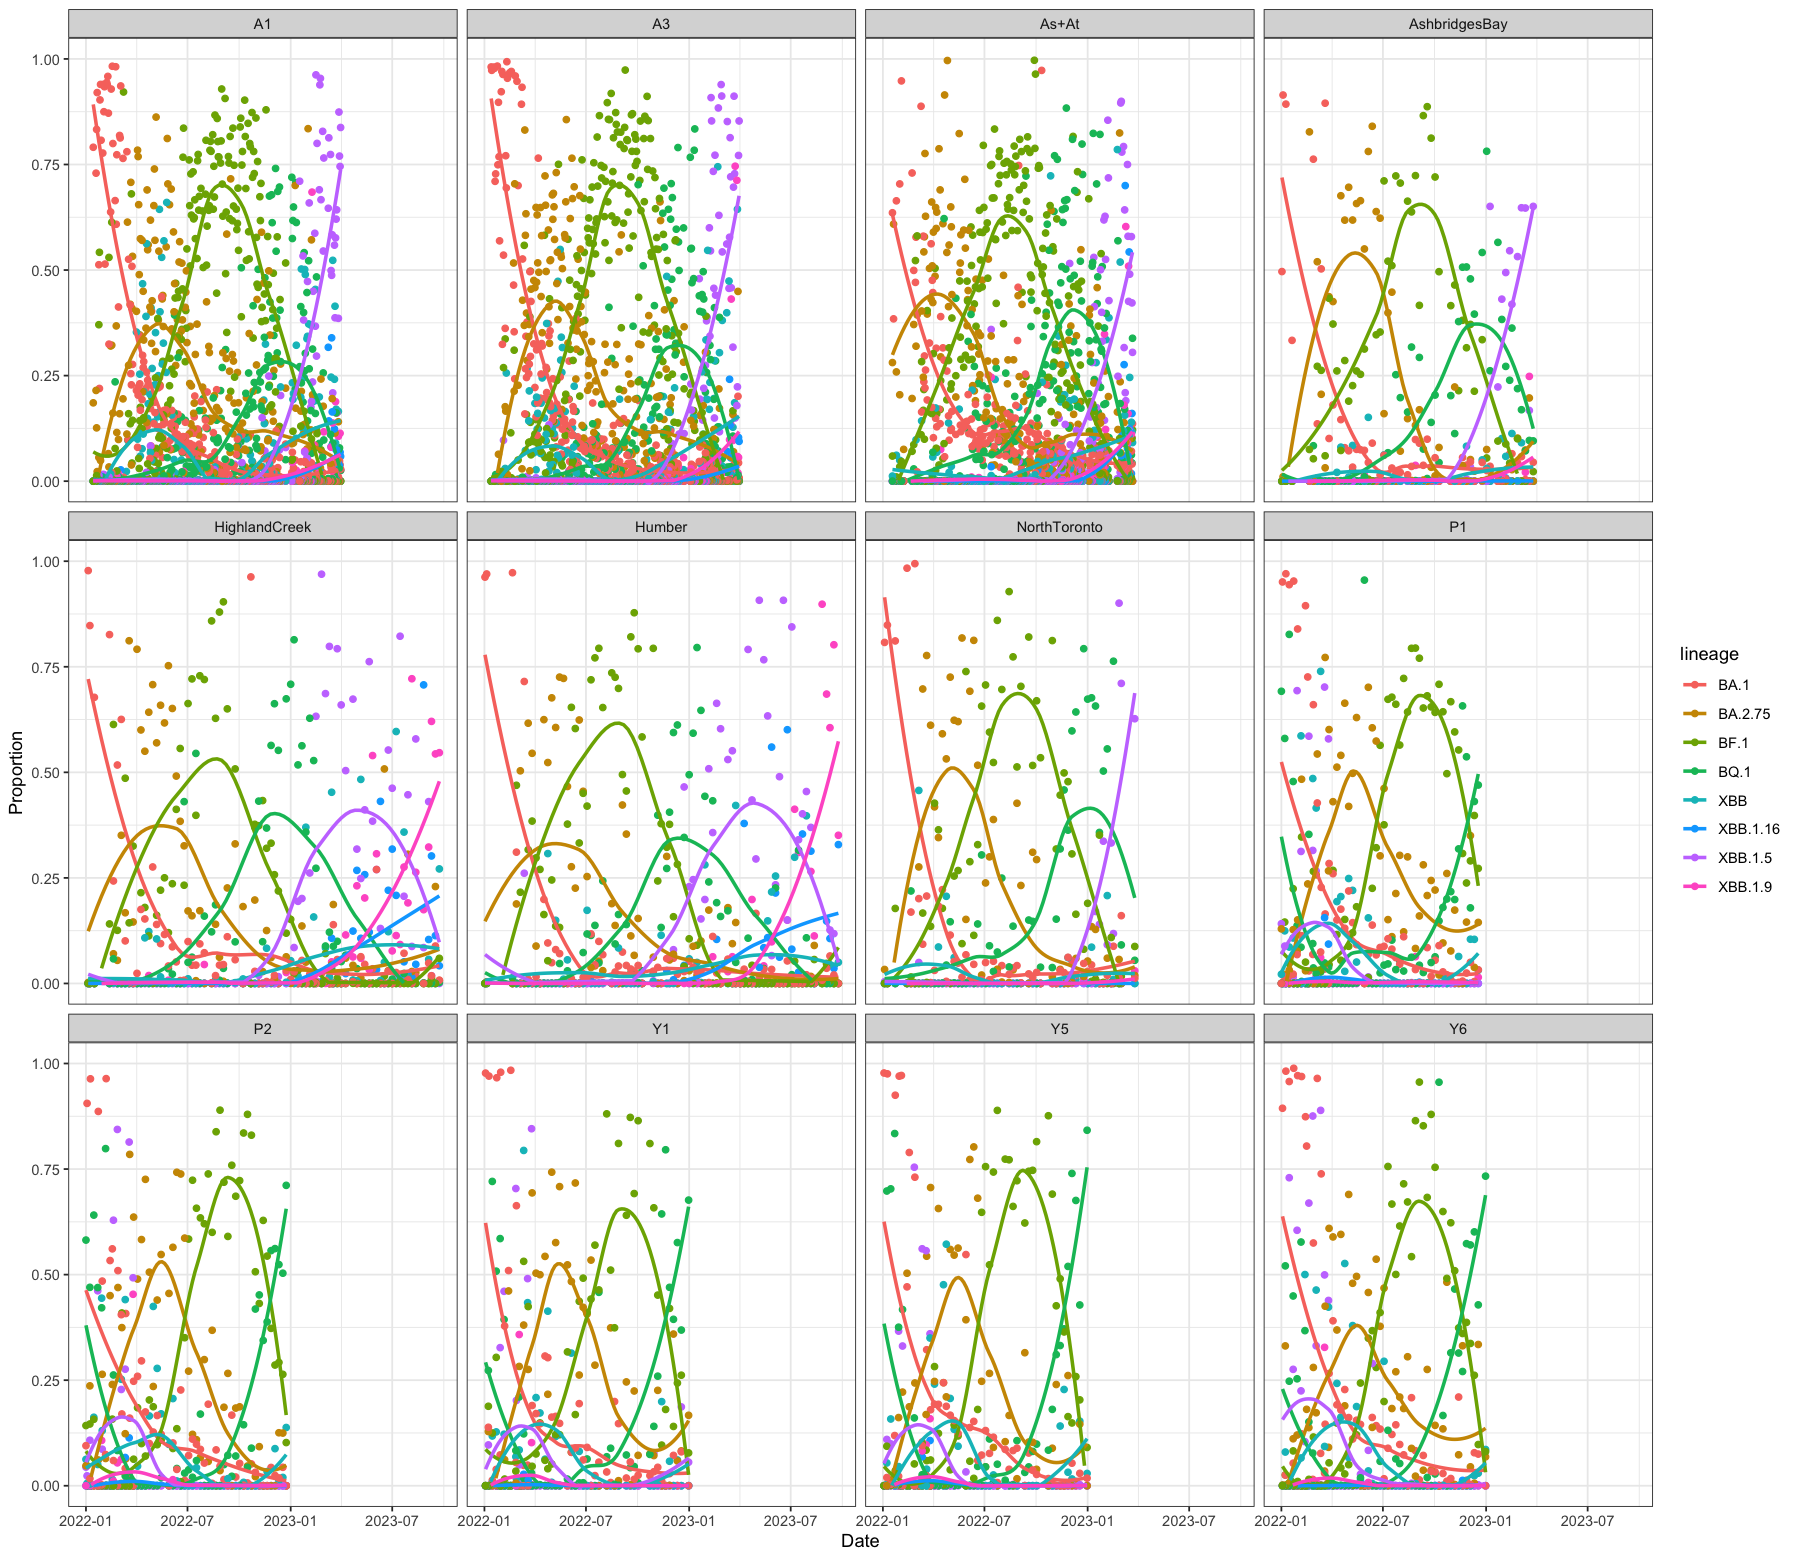

In [5]:
options(repr.plot.width = 15, repr.plot.height = 13)

# Clearly there are date input errors
res$date <- gsub("2018", "2022", as.character(res$date))
res$date <- gsub("2019", "2022", as.character(res$date))
res$date <- lubridate::ymd(res$date)
# York and Peel appear to have been input a year late?
#res$date[res$location %in% c("P1", "P2", "Y1", "Y5", "Y6")] <- 
#    res$date[res$location %in% c("P1", "P2", "Y1", "Y5", "Y6")] + years(1)

# As and At are pooled aircraft sewage, but with different samplers
# For now, assume that these are consistent.
res$location <- ifelse(res$location %in% c("As", "At"), "As+At", res$location)

gg <- autoplot(res, date_col = "date") +
    facet_wrap(~ location) +
    geom_smooth(formula = y ~ x, se = FALSE, method = "loess") +
    theme_bw()
suppressWarnings(print(gg))


In [ ]:
over2 <- dplyr::filter(coco,
    location %in% c("AshbridgesBay", "NorthToronto", "HighlandCreek", "Humber")
)

res2 <- provoc(
    formula = count / coverage ~ BA.1 +
        BA.2.75 + BF.1 + BQ.1 + XBB +
        XBB.1.16 + XBB.1.5 + XBB.1.9,
    data = over2,
    lineage_defs = barcodes,
    by = "sra",
    bootstrap_samples = 100
)


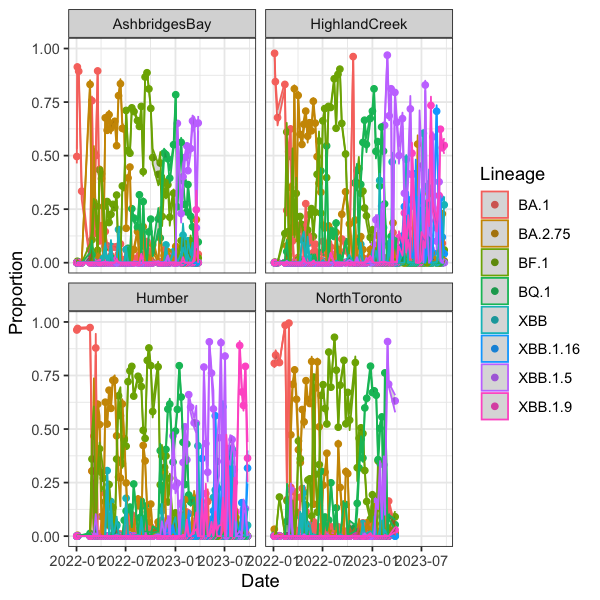

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 5)
res2$date <- ymd(res2$date)

gg <- autoplot(res2, date_col = "date") +
    facet_wrap(~ location) +
    geom_ribbon(aes(ymin = ci_low, ymax = ci_high), alpha = 0.2) +
    theme_bw() +
    labs(
        x = "Date", y = "Proportion",
        colour = "Lineage"
    )
suppressWarnings(print(gg))
